# Microbiome analyzing for Léo

This notebook aims to show how to analyze microbiome data. The dataset contains several studies (each one identified by a `study_accession` identifier). One can expect (strong) group effect, so we analyze them independently in the following, but it might be worth / easier to treat them all together.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Random state for reproductibility
random_state = 42

## Data

The Metagenomic Species Pan-genomes (MSPs) correspond roughly to microbial species. In fact, one heuristic to analyze gut samples and infer their microbiome composition is to :
 - sequence the genes in bulk (*shotgun sequencing*) 
 - cluster co-abundant genes across these samples in order to identify pseudo-microbial species (the *MSP*)

Here, the metagenomic samples have already been analyzed and we have access to their composition in MSP, also known as *abundance data*.

Moreover, once the MSP are defined, one can derive from their gene composition a phylogenetic tree. We can define a distance matrix from there, using the phylogenetic distance, defined as the patristic distance on the phylogenetic tree between the MSP. It is computed using `dendropy` the first time, and then loaded. (It is maybe not useful for you, but I let it just in case ;) 

In [2]:
distance_matrix_file = './shotgun/distance_matrix.csv'

try:
    distances = pd.read_csv(distance_matrix_file, header=0, index_col=0)
except:
    import dendropy
    tree_file = './shotgun/tree.nwk'
    tree = dendropy.Tree.get(path=tree_file,schema='newick')
    pdm = tree.phylogenetic_distance_matrix()
    pdm.as_data_table().write_csv(distance_matrix_file)
    distances = pd.read_csv(distance_matrix_file, header=0, index_col=0)

ModuleNotFoundError: No module named 'dendropy'

### Abundance data

We load the data and keep only the MSP that are in the tree (and for which we have a distance information). 

We also separate the abundance data from the metadata.
The prevalence of a MSP is defined as the proportion of samples that contains this MSP (e.g. that are > 0).
It allows to filter out a large proportion of the MSP and to reduce the dimensionality.
There is no thumb rule, but I would advise something < 0.5.

As we are interested in predicting the CRC, we drop the 7 patients for who this information is not available.

In [158]:
load_file = 'datasets/microbiome_leo/shotgun/CRC_msp_data.csv'
df = pd.read_csv(load_file, low_memory=False)
#distances.columns = [col.replace(' ','_') for col in distances.columns]
#distances.set_index(distances.columns, inplace=True)

#to_drop_columns = [col for col in df.columns if (col.startswith('msp'))]# and col not in distances.columns)]
#df.drop(to_drop_columns, axis=1, inplace=True)
msp_columns = [col for col in df.columns if col.startswith('msp')]

# Filter the non-prevalent msp
prevalence = df[msp_columns].astype(bool).sum(axis=0) / df.shape[0]


# TODO: change the threshold to a lower value
prevalence_threshold = 0.1 # Set high to spare computation time
prevalence_mask = prevalence < prevalence_threshold
non_prevalent_msp = prevalence[prevalence_mask].index.tolist() # List of non-prevalent msp e.g. the msp that are in less than 50% of the samples
df.drop(non_prevalent_msp, axis=1, inplace=True)
#distances.drop(index=non_prevalent_msp, inplace=True)
#distances.drop(columns=non_prevalent_msp, inplace=True)

# Remaining MSP
msp_columns = [col for col in df.columns if col.startswith('msp')]

# Extract the distance matrix
#C = distances.to_numpy()
#C /= np.median(C)

# Keep only rows with the CRC status available
df = df[df['health_status'].notna()]

# Compute a scaling factor to avoid too small values : the inverse of the median positive values
# min_nz = min_nonzero(df[msp_columns].to_numpy().flatten())
abundances = df[msp_columns]
pos_ab = abundances[abundances > 0].to_numpy()
median_abundance = np.median(pos_ab[~np.isnan(pos_ab)])
scaling_factor = 1 / median_abundance

# Split by dataset and by abundance / metadata=targets
datasets, targets = [], []
for study_accession in df['study_accession'].unique():
    dataset = df[df['study_accession']== study_accession]
    abundance_data = scaling_factor * dataset[msp_columns].astype(float).to_numpy()
    # abundance_data = dataset[msp_columns].astype(float).to_numpy()
    metadata = dataset.drop(msp_columns, axis=1)
    # plt.hist(abundance_data.flatten())
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.show()
    # plt.hist(np.log(1+abundance_data.flatten()))
    # plt.xscale('log')
    # plt.show()
    datasets.append(abundance_data)
    targets.append(metadata)


In [159]:
datasets[0].shape

(644, 526)

In [3]:
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from create_model import load_model_no_train
device = "cuda:3"

In [167]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
rf = RandomForestClassifier()
clf_lasso = LogisticRegression(random_state=0, penalty="l1", max_iter=1000, solver="liblinear")
clf_l2 = LogisticRegression(random_state=0, max_iter=1000, penalty="l2")
gbt = GradientBoostingClassifier()

from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from create_model import load_model_no_train

checkpoint = "linear62341_6hogpy0g_150"
model_5_step = TabPFNClassifier(device=device)#, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model_5_step.c
config["num_features"] = 2000
model_5_step.c["max_num_features"] = 2000
model_pytorch_5_step = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model_5_step.max_num_features = 2000
model_5_step.model = model_pytorch_5_step

checkpoint = "linear44856_62y4rq7r_210"
model_10_step = TabPFNClassifier(device=device)#, no_preprocess_mode=True)
#model = GradientBoostingClassifier()
config = model_10_step.c
config["num_features"] = 2000
model_10_step.c["max_num_features"] = 2000
model_pytorch_10_step = load_model_no_train("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, config, 0)[0]
model_10_step.max_num_features = 2000
model_10_step.model = model_pytorch_10_step

Using style prior: True
{'recompute_attn': True}
Using cuda:3 device
Batch size: 1
DataLoader.__dict__ {'num_features': 100, 'num_steps': 8192, 'batch_size': 1, 'eval_pos_seq_len_sampler': <function create_dataloader.<locals>.eval_pos_seq_len_sampler at 0x7f0b6a7f2940>, 'seq_len_maximum': 10, 'device': 'cuda:3', 'get_batch_kwargs': {'hyperparameters': {'lr': 0.0001, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 8192, 'verbose': False, 'mix_activations': True, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'normalize_by_used_features': True, 'num_features_used': <fu

In [43]:
pd.concat(targets)["health_status"]

0       P
1       P
2       P
3       P
4       H
       ..
1595    P
1596    P
1597    P
1598    P
1599    P
Name: health_status, Length: 1593, dtype: object

In [168]:
target = "health_status"
X = datasets[4]
y = targets[4][target]
# concatenate all datasets
#X = np.concatenate(datasets, axis=0)
#y = pd.concat(targets)[target]

In [154]:
# print all shapes
for X, y in dataset_X_y.values():
    print(X.shape, y.shape)
    

(644, 1116) (644,)
(104, 1116) (104,)
(82, 1116) (82,)
(128, 1116) (128,)
(199, 1116) (199,)
(156, 1116) (156,)
(30, 1116) (30,)
(1593, 1116) (1593,)


In [146]:
from sklearn.preprocessing import LabelEncoder

In [169]:
dataset_X_y = {}
for i in range(len(datasets)):
    X = datasets[i]
    y = targets[i][target]
    # label encoding
    le = LabelEncoder()
    y = le.fit_transform(y)
    if np.unique(y).shape[0] > 1:
        dataset_X_y[str(i)] = (X, y)
# add concatenated dataset
X = np.concatenate(datasets, axis=0)
y = pd.concat(targets)[target]
le = LabelEncoder()
y = le.fit_transform(y)
dataset_X_y["all"] = (X, y)

In [170]:
model_names = ["Random Forest", "Lasso", "L2", "Gradient Boosting", "TabPFN 5 steps", "TabPFN 10 steps"]
models = [rf, clf_lasso, clf_l2, gbt, model_5_step, model_10_step]
n_folds = 3
n_datasets = len(datasets)
scores = np.zeros((n_datasets, n_folds, len(models)))
for dataset_index, (X, y) in enumerate(dataset_X_y.values()):
    for i in range(n_folds):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        if len(np.unique(y_train)) > 1:
            for model_name, model in zip(model_names, models):
                if "TabPFN" in model_name:
                    model.fit(X_train, y_train, overwrite_warning=True)
                else:
                    model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                scores[dataset_index, i, model_names.index(model_name)] = balanced_accuracy_score(y_test, y_pred)
        else:
            print("Only one class in the dataset, skipping")
            scores[dataset_index, i, :] = np.nan

/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [171]:
# invert axis 1 and 2
scores = np.swapaxes(scores, 1, 2)

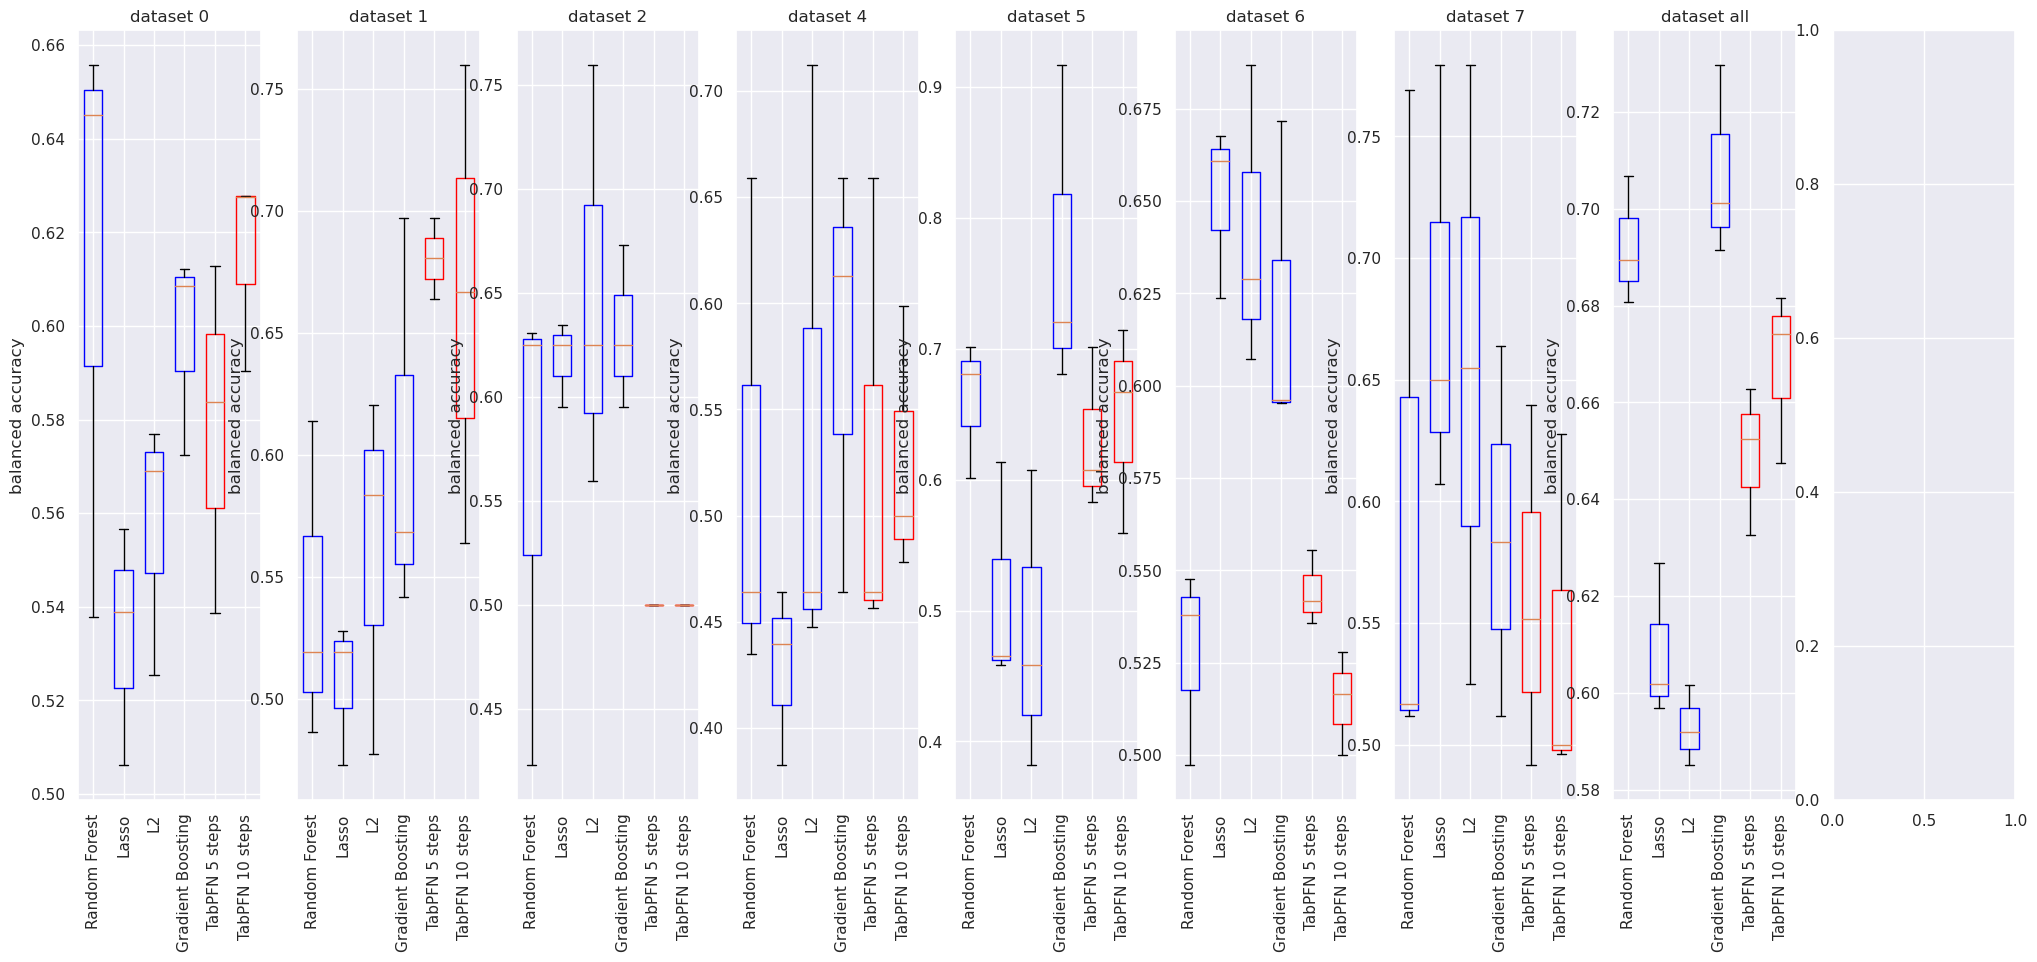

In [172]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=n_datasets, figsize=(25, 10))
for i, dataset_id in enumerate(dataset_X_y.keys()):
    for j, (model_name, model) in enumerate(zip(model_names, models)):
        if "TabPFN" in model_name:
            # fill box in red
            if "original" in model_name:
                axes[i].boxplot(scores[i, model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6, boxprops=dict(color="green"))
            else:
                axes[i].boxplot(scores[i, model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6, boxprops=dict(color="red"))
        else:
            axes[i].boxplot(scores[i, model_names.index(model_name), :], positions=[model_names.index(model_name)], widths=0.6, boxprops=dict(color="blue"))
        axes[i].set_xticks(range(len(model_names)))
        axes[i].set_xticklabels(model_names)
        axes[i].set_title(f"dataset {dataset_id}")
        axes[i].set_ylabel("balanced accuracy")
        axes[i].grid(True)
        # rotate x tick labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)


## Dimensionality reduction

Here we aim at reduce dimensionality of the MSP as probably only a subset of them is informative. We thus perform PCA.

*Disclaimer: Linear dimensionality reduction method are know to perform bad on microbiome data, it is a toy example*

We create two toy models :
 - `IndependentPCA` that takes as input a list of datasets, and apply a PCA to each of them. 
 - `GlobalPCA` that takes as input a list of datasets, and concatenates them before applying a single global PCA.

We set the number of components `n_components=6` as they are 113 remaining MSP (which corresponds to keeping roughly ~$5\%$ of them) with the prevalence threshold we used.

*Note : For the PCA of $X$, we use the formalism $X \simeq SL$, with $X \in \mathbb{R}^{n \times p}, S \in \mathbb{R}^{n \times k}, L \in \mathbb{R}^{k \times p}$, with $S$ being denoted as the **scores** matrix and $L$ being denoted as the **loadings** matrix.*

In [21]:
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin

class IndependentPCA(TransformerMixin):
    """Apply one PCA per dataset"""
    def __init__(self, n_components):
        self.n_components = n_components
        self.all_S = [] # The scores matrices
        self.all_L = [] # The loadings matrices
        
    def fit(self, X, y=None):
        self.pcas_ = []
        for i in range(len(X)):
            pca = PCA(n_components=self.n_components)
            pca.fit(X[i])
            self.all_S.append(pca.transform(X[i]))
            self.all_L.append(pca.components_)
            self.pcas_.append(pca)
        return self

    def transform(self, X, y=None):
        return self.all_S
    
class GlobalPCA(TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.all_S = [] # The scores matrices
        self.all_L = [] # The loadings matrices
        
    def fit(self, X, y=None):

        X_concat = np.concatenate(X) # concatenate all datasets
        pca = PCA(n_components=self.n_components)
        pca.fit(X_concat) # apply one global PCA
        self.all_L = [pca.components_ for _ in range(len(X))]# construct one loadings matrix for each input dataset
        for i in range(len(X)):
            S = pca.transform(X[i])
            self.all_S.append(S) # construct one score matrix for each input dataset
        return self

    def transform(self, X, y=None):
        return self.all_S

In [22]:
models = {'IndependentPCA': IndependentPCA(n_components=6),
          'GlobalPCA': GlobalPCA(n_components=6)}

### Prediction of third-party targets

We now fit each model on the complete datasets, and we predict third-party targets, to assess the relevance of the latent features.

More specifically, I illustrate this approach on two points :
 - *Regression tasks* : 
   - Prediction of the **BMI** (the weight)
   - Prediction of the **GeneRichness** (a measure of the gene diversity of the sample that is shown to correlate well with multiple metabolic factors)
 - *Classification tasks* :
   - Prediction of the **health_status** (`P` for *patient* or `H` for *healthy*)
   - Prediction of the **host_subphenotype** (The stage of the disease)

(`WARNING`: I don't remember to what do correspond the metrics I used for the `XGBClassifier` and `XGBRegressor` haha....)

In [18]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/home/soda/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [23]:
# Fit each model on the complete datasets
for model_name, model in models.items():
    model.fit(datasets, y=None)
    models[model_name] = model

In [24]:
## Helper functions for comparing the performances of the models

def extract_classification_target(df, target_name):
    """Binarize the classification target."""
    new_df = df.copy()
    target_arr = new_df[target_name].to_numpy()
    is_nan = pd.isna(target_arr)
    # We have to replace NaN by str, in order to find uniques elements
    # Then we transform them back to NaN
    target_arr[is_nan] = 'nan'
    le = LabelEncoder()
    y = le.fit_transform(target_arr)
    y = np.where(is_nan, np.nan, y)
    return y


def compare_models(models, targets, target_name='target', type='regression'):
    """Compare the predictions of the models either on `regression` or on `classification` targets.
    
    Parameters
    ----------
    models : dict
        Dictionary of models to evaluate.
    targets : list of 1D-arrays
        list containing the target values for each dataset.
    target_name : str, default='target'
        Name of the target variable.
    type : str, default='regression'
        Type of target to evaluate the models on. Any of {'regression', 'classification'}.
    """

    if type == 'regression':
        estimator = XGBRegressor()
    elif type == 'classification':
        estimator = XGBClassifier()
    else:
        raise ValueError('type must be either "regression" or "classification"')
    train_score, test_score = {}, {}
    for model_name, model in models.items():
        latent_representations = model.all_S
        train_score[model_name], test_score[model_name] = [], []
        for i, dataset in enumerate(latent_representations):
            y = targets[i][~np.isnan(targets[i])]
            x = dataset[~np.isnan(targets[i])]
            try:
                if type == 'classification':
                    x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, stratify=y)
                else: # type == 'regression'
                    x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3)
                estimator.fit(x_train, y_train)
                if type == 'classification':
                    y_pred_train = estimator.predict(x_train)
                    y_pred_test = estimator.predict(x_test)
                    train_score[model_name].append(accuracy_score(y_train, y_pred_train))
                    test_score[model_name].append(accuracy_score(y_test, y_pred_test))
                else: # type == 'regression'
                    train_score[model_name].append(estimator.score(x_train, y_train))
                    test_score[model_name].append(estimator.score(x_test, y_test))
            except: # Not enough data
                print('pass')
                pass
    fig, axs = plt.subplots(1,2,figsize=(15,10))
    axs[0].boxplot(train_score.values(), labels=train_score.keys())
    axs[0].title.set_text('Train score for the {} prediction'.format(target_name))
    axs[0].legend()
    axs[1].boxplot(test_score.values(), labels=test_score.keys())
    axs[1].title.set_text('Test score for the {} prediction'.format(target_name))
    axs[1].legend()
    plt.show()


In [25]:
classification_targets = ['host_subphenotype','health_status']
regression_targets = []#['BMI','GeneRichness']

# Format the targets
all_targets = {}
for regression_target in regression_targets:
    all_targets[regression_target] = [target[regression_target] for target in targets]
for classification_target in classification_targets:
    all_targets[classification_target] = [extract_classification_target(df=target, target_name=classification_target).flatten() for target in targets]

for target in regression_targets:
    compare_models(models=models, targets=all_targets[target], target_name=target, type='regression')
for target in classification_targets:
    compare_models(models=models, targets=all_targets[target], target_name=target, type='classification')

pass
pass


: 